In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

from sklearn import svm
from sklearn import metrics
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import gudhi as gd
from ripser import Rips
from persim.landscapes import PersistenceLandscaper

In [3]:
iris = datasets.load_iris()
X = pd.DataFrame(iris.data, columns = iris.feature_names)
y = iris['target']

In [120]:
X_setosa = X[y == 0]
X_versicolor = X[y == 1]
X_virginica = X[y == 2]

X_setosa.shape[0] + X_versicolor.shape[0] + X_virginica.shape[0] == X.shape[0]

True

In [92]:
twof_setosa = [X_setosa[list(comb)] for comb in list(combinations(X.columns, 2))]
threef_setosa = [X_setosa[list(comb)] for comb in list(combinations(X.columns, 3))]
fourf_setosa = [X_setosa[list(comb)] for comb in list(combinations(X.columns, 4))]

twof_versicolor = [X_versicolor[list(comb)] for comb in list(combinations(X.columns, 2))]
threef_versicolor = [X_versicolor[list(comb)] for comb in list(combinations(X.columns, 3))]
fourf_versicolor = [X_versicolor[list(comb)] for comb in list(combinations(X.columns, 4))]

twof_virginica = [X_virginica[list(comb)] for comb in list(combinations(X.columns, 2))]
threef_virginica = [X_virginica[list(comb)] for comb in list(combinations(X.columns, 3))]
fourf_virginica = [X_virginica[list(comb)] for comb in list(combinations(X.columns, 4))]

In [76]:
def get_landscape(two_feature_dfs, three_feature_dfs, four_feature_dfs):
    landscapes = []
    rips = Rips(maxdim = 2)

    for f in range(len(two_feature_dfs)):
        dgm = rips.fit_transform(two_feature_dfs[f])
        landscaper = PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)
        flat = landscaper.fit_transform(dgm)
        landscapes.append(flat)

    for f in range(len(three_feature_dfs)):
        dgm = rips.fit_transform(three_feature_dfs[f])
        landscaper = PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)
        flat = landscaper.fit_transform(dgm)
        landscapes.append(flat)

    for f in range(len(four_feature_dfs)):
        dgm = rips.fit_transform(four_feature_dfs[f])
        landscaper = PersistenceLandscaper(hom_deg=1, start=0, stop=2.0, num_steps=500, flatten=True)
        flat = landscaper.fit_transform(dgm)
        landscapes.append(flat)
    
    return landscapes

In [155]:
setosa_landscape = get_landscape(twof_setosa, threef_setosa, fourf_setosa)
versicolor_landscape = get_landscape(twof_versicolor, threef_versicolor, fourf_versicolor)
virginica_landscape = get_landscape(twof_virginica, threef_virginica, fourf_virginica)

len(versicolor_landscape) == 6 + 4 + 1

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


True

In [171]:
def populate(landscapes):
    u = np.max([len(a) for a in landscapes])
    ls = np.zeros((11, u))

    for i in range(len(landscapes)):
        ls[i, 0:len(landscapes[i])] = landscapes[i]

    pca_iris = PCA(n_components=3)
    ls_transformed = pca_iris.fit_transform(ls)

    # return ls, comp_iris
    return ls, ls_transformed

setosa_ls, comp_setosa = populate(setosa_landscape)
versicolor_ls, comp_versicolor = populate(versicolor_landscape)
virginica_ls, comp_virginica = populate(virginica_landscape)

1. There are 11 rows in total, and each row represent the persistence diagram of each arrangement, which is 6 + 4 + 1
2. 14500 is the max range of the landscape,

In [172]:
print(setosa_ls.shape)
print(versicolor_ls.shape)
print(virginica_ls.shape)

(11, 14500)
(11, 8500)
(11, 9000)


In [173]:
print(comp_setosa.shape)
print(comp_versicolor.shape)
print(comp_virginica.shape)

(11, 3)
(11, 3)
(11, 3)


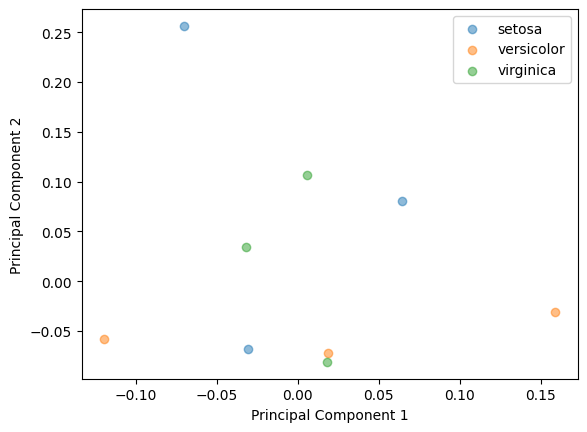

In [174]:
plt.figure()
plt.scatter(comp_setosa[0], comp_setosa[1], label='setosa', alpha=0.5)
plt.scatter(comp_versicolor[0], comp_versicolor[1], label='versicolor', alpha=0.5)
plt.scatter(comp_virginica[0], comp_virginica[1], label='virginica', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

In [175]:
# Produce lists of points
pts_setosa = [[comp_setosa[0,i], comp_setosa[1,i]] for i in range(len(comp_setosa[0]))]
pts_versicolor = [[comp_versicolor[0,i], comp_versicolor[1,i]] for i in range(len(comp_versicolor[0]))]
pts_virginica = [[comp_virginica[0,i], comp_virginica[1,i]] for i in range(len(comp_virginica[0]))]

# Instantiate indicator functions
chi_setosa = np.zeros(len(pts_setosa))
chi_versicolor = np.ones(len(pts_versicolor))
chi_virginica = np.full(len(pts_virginica), 2)

# Produce final list of points
pts = []

for p in pts_setosa:
    pts.append(p)
for p in pts_versicolor:
    pts.append(p)
for p in pts_virginica:
    pts.append(p)

pts = np.array(pts)

# Append indicator functions
chi = np.hstack((chi_setosa, chi_versicolor, chi_virginica))

In [176]:
# Split points and indicator arrays
P_train, P_test, c_train, c_test = train_test_split(pts, chi, train_size=.8)

print(P_train.shape)
print(c_train.shape)

(7, 2)
(7,)


In [177]:
# Instantiate support vector classifier
clf = svm.SVC()

# Fit model
clf.fit(P_train, c_train)

# Evaluate model performance using accuracy between ground truth data and predicted data
print(f'Model accuracy: {metrics.accuracy_score(c_test, clf.predict(P_test)):.2f}')

Model accuracy: 0.00
